In [1]:
import numpy as np
import sys
sys.path.insert(0,'..')
import emlddmm
from emlddmm import read_data, interp
import dti
import matplotlib.pyplot as plt
import os
import h5py
import torch
import pandas as pd

jacobian = lambda X,dv : np.stack(np.gradient(X, dv[0],dv[1],dv[2], axis=(0,1,2)), axis=-1)

In [2]:
# file paths

hist_to_mri_path = '/home/brysongray/data/human_amyg/amyg_maps_for_bryson/registered_histology_to_mri_displacement.vtk'
dti_path = '/home/brysongray/data/dki/dki_tensor.nii.gz'
mri_reg_path = '/home/brysongray/data/human_amyg/amyg_maps_for_bryson/mri_avg_b0_to_registered_histology.vtk'
st_path = '/home/brysongray/data/human_amyg/sta_output'
nissl_myelin_rigid = '/home/brysongray/data/human_amyg/nissl_myelin_rigid'
reg_to_input = '/home/brysongray/data/human_amyg/amygdala_outputs_v00/registered_histology/input_histology_to_registered_histology/transforms'

In [3]:
slice = 175

In [4]:
# load disp and original image
xJ,hist_to_mri,_,_ = read_data(hist_to_mri_path)
hist_to_mri_T = np.stack((hist_to_mri[0][1], hist_to_mri[0][0], hist_to_mri[0][2])).transpose(0,2,1,3)
xI,I,title,_ = read_data(mri_reg_path)

dx = np.array([(x[1] - x[0]) for x in xI])
# get transformed coordinates
XI = np.stack(np.meshgrid(xI[0],xI[1],xI[2], indexing='ij'))

X = hist_to_mri[0] + XI

(<Figure size 432x288 with 15 Axes>,
 [[<AxesSubplot: >,
   <AxesSubplot: >,
   <AxesSubplot: >,
   <AxesSubplot: >,
   <AxesSubplot: >],
  [<AxesSubplot: >,
   <AxesSubplot: >,
   <AxesSubplot: >,
   <AxesSubplot: >,
   <AxesSubplot: >],
  [<AxesSubplot: >,
   <AxesSubplot: >,
   <AxesSubplot: >,
   <AxesSubplot: >,
   <AxesSubplot: >]])

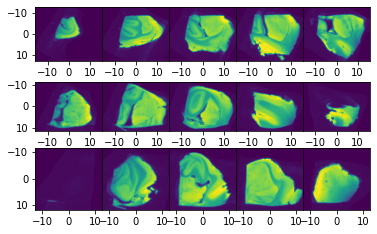

In [8]:
emlddmm.draw(I,xI)

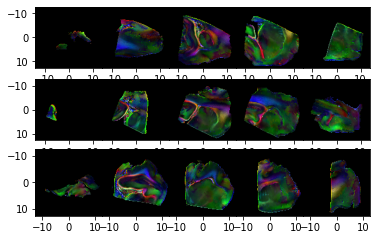

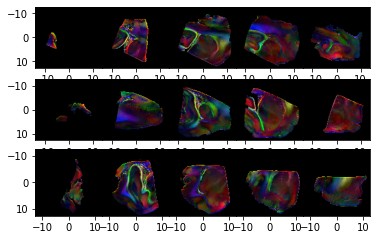

In [7]:
# read dti
xT, T = dti.read_dti(dti_path)
dti.visualize(T,xT)
# transpose and switch components to match histology space orientation
T = np.stack((T[...,0,0],T[...,1,1],T[...,2,2],T[...,0,1],T[...,0,2],T[...,1,2]),-1)
T = np.stack((T[...,1],T[...,3],T[...,5],T[...,3],T[...,0],T[...,4],T[...,5],T[...,4],T[...,2]), axis=-1).transpose(1,0,2,3)
# T.transpose(1,0,2,3,4)
T = T.reshape(T.shape[:3]+(3,3))
xT = [xT[1], xT[0], xT[2]]
dti_original = dti.visualize(T,xT)



### resample dti in registered space and apply ppd to rotate tensors 

In [9]:
# resample dti in registered histology space
Tnew = dti.interp_dti(T,xT,X)
# rotate tensors
J = jacobian(X.transpose(1,2,3,0),dx)
Q = dti.ppd(Tnew,J)
Tnew = Q @ Tnew @ Q.transpose(0,1,2,4,3)

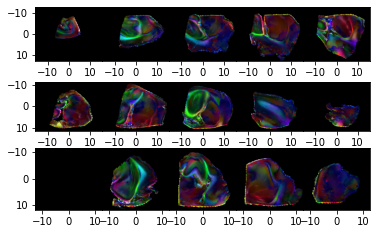

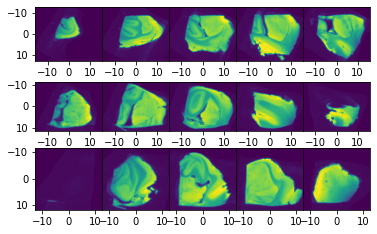

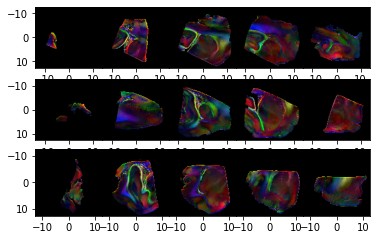

In [10]:
# visualize transformed dti
fig1 = plt.figure()
dti_to_hist = dti.visualize(Tnew,xI,fig=fig1)

# visualize avg b0 in registered histology space
fig2 = plt.figure()
emlddmm.draw(I,xI,fig2)

# visualize original dti
fig3 = plt.figure()
T_img = dti.visualize(T,xT,fig=fig3)